In [1]:
!wget --no-check-certificate https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip \
                -O /content/cassavaleafdata.zip

!unzip /content/cassavaleafdata.zip
%cd /content/cassavaleafdata

Streaming output truncated to the last 5000 lines.
  inflating: cassavaleafdata/train/cgm/train-cgm-68.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-680.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-681.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-682.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-683.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-684.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-685.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-686.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-687.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-688.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-689.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-69.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-690.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-691.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-692.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-693.jpg  
  infla

## Import required libraries

In [2]:
import os
import random
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image

In [3]:
!mkdir model

In [4]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Load dataset

In [5]:
data_paths = {
    'train': './train',
    'valid': './validation',
    'test': './test'
}

In [6]:
def loader(path):
    return Image.open(path)

In [7]:
%%time
img_size = 150
BATCH_SIZE = 512

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(root=data_paths['train'], loader=loader, transform=train_transform)
valid_data = datasets.ImageFolder(root=data_paths['valid'], transform=train_transform)
test_data = datasets.ImageFolder(root=data_paths['test'], transform=train_transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

CPU times: user 28.1 ms, sys: 3.77 ms, total: 31.8 ms
Wall time: 33.3 ms


In [16]:
labels_dict = {
    "cbb": "Cassava Bacterial Blight (CBB)",
    "cbsd": "Cassava Brown Streak Disease (CBSD)",
    "cgm": "Cassava Green Mottle (CGM)",
    "cmd": "Cassava Mosaic Disease (CMD)",
    "healthy": "Healthy"
}

In [33]:
def plot_images(data_dir, label, num_samples=6):
    data_dir = os.path.join(data_dir, label)
    files = os.listdir(data_dir)[:num_samples]
    fig, ax = plt.subplots(2, 3, figsize=(14, 7))
    row = 0
    for idx, file in enumerate(files):
        img_path = os.path.join(data_dir, file)
        img = Image.open(img_path)

        if idx == 3:
            row += 1
        ax[row, idx % 3].imshow(img)
        ax[row, idx % 3].set_title(labels_dict[label])
        ax[row, idx % 3].axis('off')
    plt.tight_layout()
    plt.show()

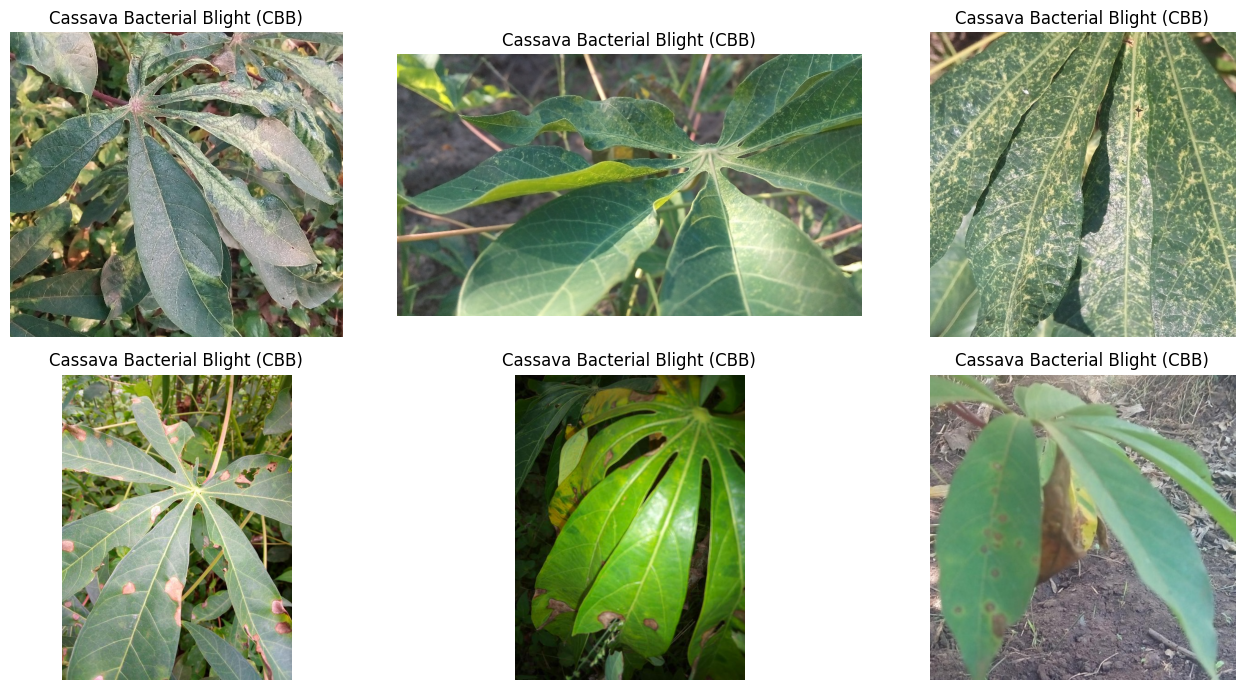

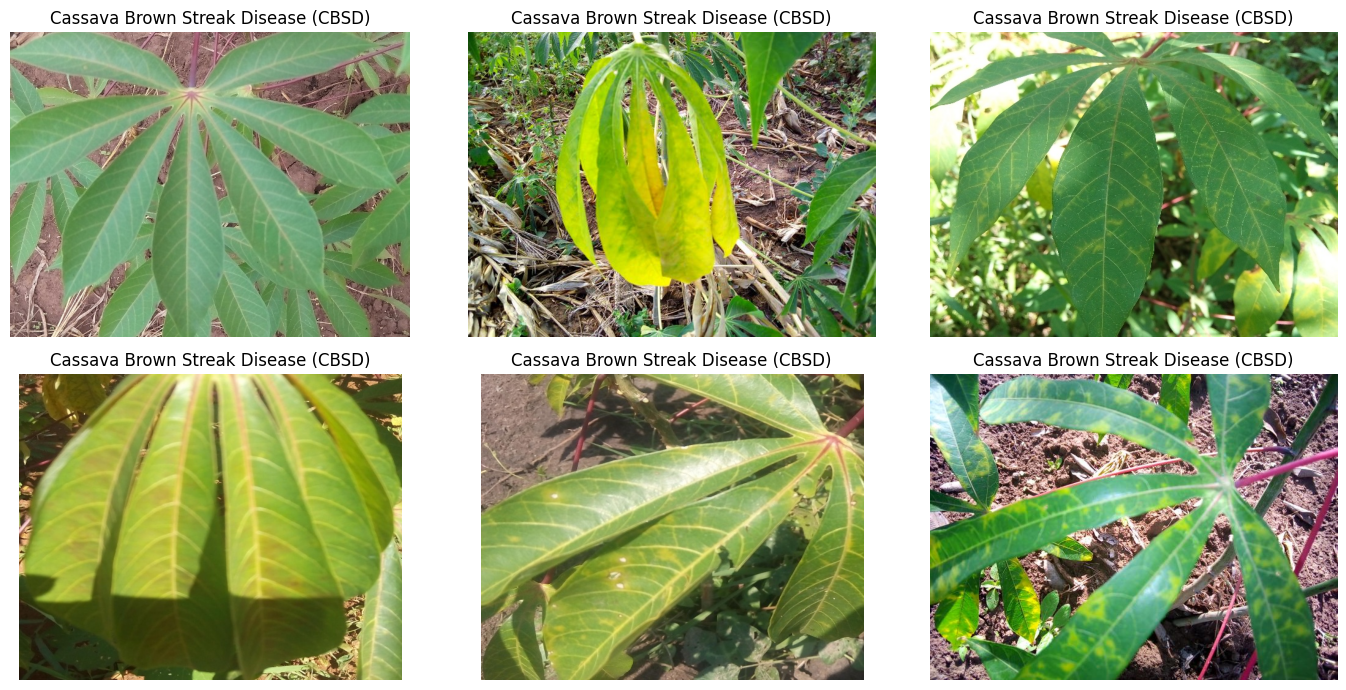

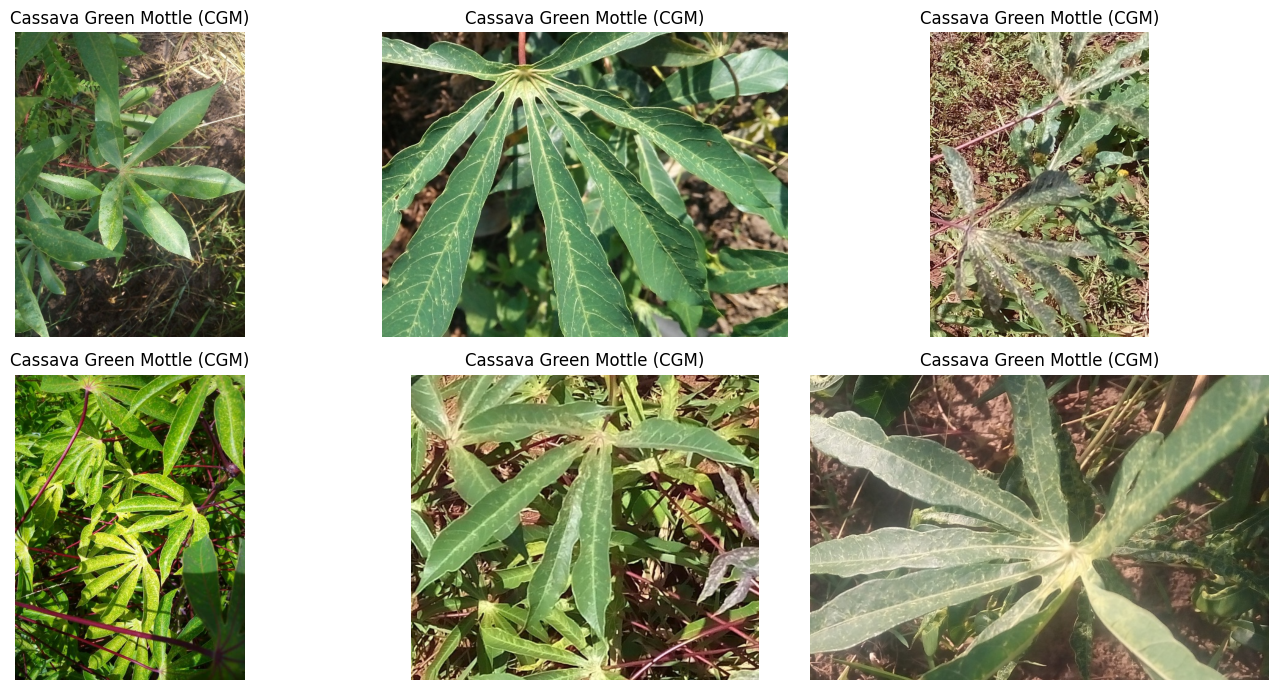

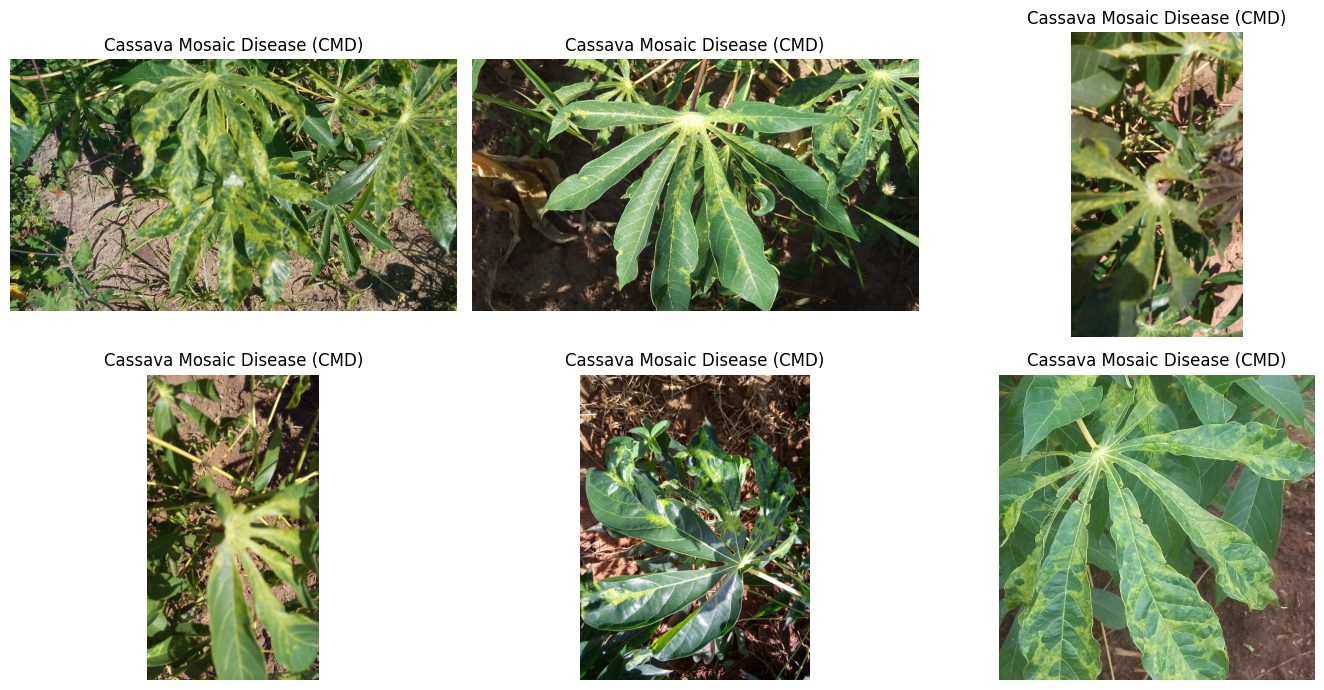

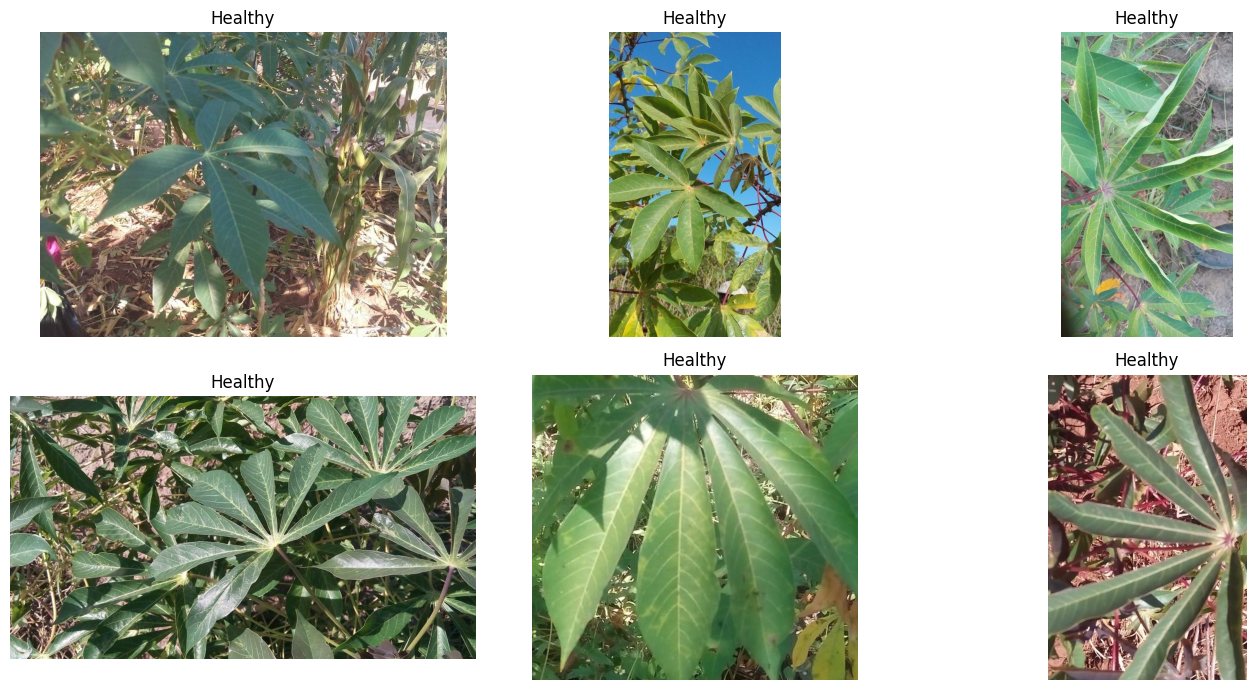

In [34]:
plot_images(data_paths['train'], 'cbb')
plot_images(data_paths['train'], 'cbsd')
plot_images(data_paths['train'], 'cgm')
plot_images(data_paths['train'], 'cmd')
plot_images(data_paths['train'], 'healthy')

## Define LeNet

In [42]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding='same')
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 35 * 35, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, X):
        X = F.relu(self.avgpool1(self.conv1(X)))
        X = F.relu(self.avgpool2(self.conv2(X)))
        X = self.flatten(X)
        X = self.fc1(X)
        X = self.fc2(X)
        X = self.fc3(X)
        return X

In [39]:
len(train_data.classes)

5

## Training and Evaluation

In [43]:
def train(model, train_loader, optimizer, criterion, device, epoch=0, log_interval=50):
    model.train()
    train_acc, count = 0.0, 0
    losses = []
    start_time = time.time()
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        train_acc += (outputs.argmax(dim=1) == labels).sum().item()
        count += len(labels)
        if batch_idx % log_interval == 0 and batch_idx > 0:
            elapsed = time.time() - start_time
            print(f'| epoch {epoch+1:3d} | {batch_idx:5d}/{len(train_loader):d} batches '
                f'| accuracy {train_acc/count:8.3f}'
            )
            train_acc, count = 0.0, 0
            start_time = time.time()

    epoch_acc = train_acc / count
    epoch_loss = np.mean(losses)
    return epoch_acc, epoch_loss

def evaluate(model, val_loader, criterion, device):
    model.eval()
    eval_acc, count = 0.0, 0
    losses = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            eval_acc += (outputs.argmax(dim=1) == labels).sum().item()
            count += len(labels)

    epoch_acc = eval_acc / count
    epoch_loss = np.mean(losses)
    return epoch_acc, epoch_loss

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(train_data.classes)
lr = 2e-4

lenet_model = LeNetClassifier(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters(), lr)

epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(epochs):
    epoch_start_time = time.time()

    # Training
    train_acc, train_loss = train(lenet_model, train_loader, optimizer, criterion, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(lenet_model, val_loader, criterion, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        best_loss_eval = eval_loss
        torch.save(lenet_model.state_dict(), os.path.join(save_model, 'lenet_model_cassava.pt'))

    print('-' * 59)
    print(f'| End of epoch {epoch+1:3d} | Time: {time.time() - epoch_start_time:5.2f}s '
        f'| Train Accuracy: {train_acc:8.3f} | Train Loss: {train_loss:8.3f} | '
        f'Val Accuracy: {eval_acc:8.3f} | Val Loss: {eval_loss:8.3f} '
    )
    print('-' * 59)

    # Load best model
    lenet_model.load_state_dict(torch.load(os.path.join(save_model, 'lenet_model_cassava.pt')))
    lenet_model.eval()

-----------------------------------------------------------
| End of epoch   1 | Time: 47.07s | Train Accuracy:    0.427 | Train Loss:    1.562 | Val Accuracy:    0.470 | Val Loss:    1.369 
-----------------------------------------------------------


<ipython-input-47-56c458488c1c>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_model.load_state_dict(torch.load(os.path.join(save_model, 'lenet_model_cassava.pt')))

-----------------------------------------------------------
| End of epoch   2 | Time: 48.55s | Train Accuracy:    0.470 | Train Loss:    1.348 | Val Accuracy:    0.470 | Val Loss:    1.336 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   3 | Time: 48.07s | Train Accuracy:    0.474 | Train Loss:    1.304 | Val Accuracy:    0.470 | Val Loss:    1.317 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   4 | Time: 45.86s | Train Accuracy:    0.478 | Train Loss:    1.321 | Val Accuracy:    0.503 | Val Loss:    1.344 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   5 | Time: 45.92s | Train Accuracy:    0.443 | Train Loss:    1.367 | Val Accuracy:    0.470 | Val Loss:    1.306 
--------------------------------------------------------

In [48]:
test_acc, test_loss = evaluate(lenet_model, test_loader, criterion, device)
print(f'Test Accuracy: {test_acc:8.3f} | Test Loss: {test_loss:8.3f}')

Test Accuracy:    0.518 | Test Loss:    1.235


In [49]:
def plot_results(epochs, train_accs, train_losses, eval_accs, eval_losses):
    x_range = range(epochs)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(x_range, train_losses, 'b', label='Training Loss')
    plt.plot(x_range, eval_losses, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x_range, train_accs, 'b', label='Training Accuracy')
    plt.plot(x_range, eval_accs, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

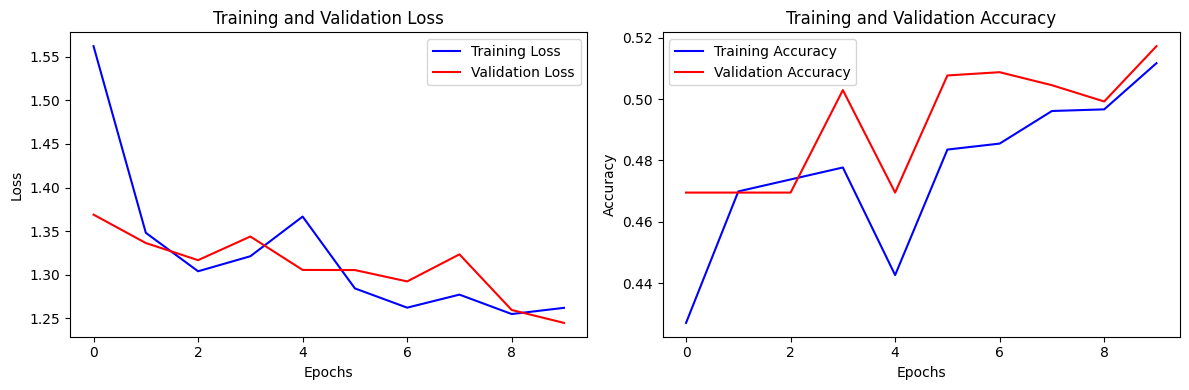

In [50]:
plot_results(epochs, train_accs, train_losses, eval_accs, eval_losses)